In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew, linregress
import statsmodels.api as sm
import seaborn as sns



In [43]:
# Liste des fichiers et lecture des données
files = {
    'Growth': 'MSCI_EUROPE_GROWTH.xlsx',
    'Large': 'MSCI_EUROPE_LARGE.xlsx',
    'Momemtum': 'MSCI_EUROPE_MOMENTUM.xlsx',
    'Quality': 'MSCI_EUROPE_QUALITY.xlsx',
    'Small': 'MSCI_EUROPE_SMALL.xlsx',
    'Value': 'MSCI_EUROPE_VALUE.xlsx',
    'Market': 'MSCI_EUROPE.xlsx',
    'LowVol': 'MSCI_EUROPE_LOW_VOL.xlsx'
}

filtered_data = {}  # Initialize the dictionary to store filtered data
annual_results = {}  # Initialize the dictionary to store annual results

In [44]:
# Boucle pour lire chaque fichier Excel, le transformer et l'enregistrer en CSV
for key, file in files.items():
    data = pd.read_excel(file)

    # Supprimer les lignes inutiles et renommer les colonnes
    data.columns = data.iloc[1]
    data = data.drop([0, 1]).reset_index(drop=True)

    # Convertir la colonne 'Date' en type datetime
    data['Date'] = pd.to_datetime(data['Date'])

    # Filtrer les données pour conserver uniquement les dates entre le 31/12/1998 et le 31/12/2024
    data = data[(data['Date'] > '1998-12-31') & (data['Date'] <= '2024-12-31')]

    # Supposons que la colonne 'Price' contient les prix
    # Convertir la colonne 'Price' en float
    data['Price'] = pd.to_numeric(data['Price'], errors='coerce')

    # Vérifier et gérer les valeurs manquantes dans 'Price'
    if data['Price'].isnull().any():
        data['Price'] = data['Price'].fillna(method='ffill')  # Remplir les valeurs manquantes par la valeur précédente

    # Calculer le '% Change' basé sur le logarithme naturel
    data['% Change'] = np.log(data['Price'] / data['Price'].shift(1))

    # Calculer le Total Return
    data['Total Return'] = (1 + data['% Change']).cumprod() - 1


    # Enregistrer les données transformées dans un fichier CSV
    csv_file = f'{key}.csv'
    data.to_csv(csv_file, index=False)

    print(f"Fichier {csv_file} créé avec succès.")

    # Store the filtered data in the dictionary
    filtered_data[key] = data

    # Calculer et afficher les statistiques descriptives, kurtosis, skewness et max drawdown
    print(f"Statistiques descriptives pour {key}:")
    print(data[['% Change', 'Total Return']].describe())

    # Calculer la kurtosis et le skewness
    change_kurtosis = kurtosis(data['% Change'].dropna())
    change_skewness = skew(data['% Change'].dropna())

    print(f"\nKurtosis pour '% Change': {change_kurtosis}")
    print(f"Skewness pour '% Change': {change_skewness}")


Fichier Growth.csv créé avec succès.
Statistiques descriptives pour Growth:
1        % Change  Total Return
count  311.000000    311.000000
mean     0.002116     -0.064985
std      0.041985      0.276475
min     -0.121008     -0.538486
25%     -0.020585     -0.288084
50%      0.008115     -0.080943
75%      0.027773      0.110121
max      0.120587      0.562152

Kurtosis pour '% Change': 0.599745968605855
Skewness pour '% Change': -0.47417205925484185
Fichier Large.csv créé avec succès.
Statistiques descriptives pour Large:
1        % Change  Total Return
count  311.000000    311.000000
mean     0.001311     -0.118573
std      0.043125      0.176956
min     -0.154896     -0.519219
25%     -0.021648     -0.263622
50%      0.008153     -0.119207
75%      0.027741     -0.007892
max      0.130241      0.361993

Kurtosis pour '% Change': 1.248754651013905
Skewness pour '% Change': -0.5935874987396389
Fichier Momemtum.csv créé avec succès.
Statistiques descriptives pour Momemtum:
1        % 

C:\Users\wilso\AppData\Local\Temp\ipykernel_1472\3446582534.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Price'] = data['Price'].fillna(method='ffill')  # Remplir les valeurs manquantes par la valeur précédente


Fichier Quality.csv créé avec succès.
Statistiques descriptives pour Quality:
1        % Change  Total Return
count  311.000000    311.000000
mean     0.003481      0.427277
std      0.038095      0.474442
min     -0.127843     -0.286599
25%     -0.016335      0.050133
50%      0.007650      0.313989
75%      0.027026      0.723759
max      0.106664      1.551406

Kurtosis pour '% Change': 0.49386713361500645
Skewness pour '% Change': -0.445278270294065
Fichier Small.csv créé avec succès.
Statistiques descriptives pour Small:
1        % Change  Total Return
count  311.000000    311.000000
mean     0.004690      0.885208
std      0.052544      0.684420
min     -0.240730     -0.281658
25%     -0.021184      0.285307
50%      0.010588      0.816474
75%      0.037591      1.499578
max      0.191300      2.410661

Kurtosis pour '% Change': 3.147125851519215
Skewness pour '% Change': -0.9652082547181479
Fichier Value.csv créé avec succès.
Statistiques descriptives pour Value:
1        % Chan

C:\Users\wilso\AppData\Local\Temp\ipykernel_1472\3446582534.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Price'] = data['Price'].fillna(method='ffill')  # Remplir les valeurs manquantes par la valeur précédente


In [45]:
beta_results = {}  # Initialize the dictionary to store beta results

# Calculer le bêta pour chaque indice par rapport à l'indice de marché
market_data = filtered_data['Market']

for key, data in filtered_data.items():
    if key != 'Market':
        # Calculer le '% Change' basé sur le logarithme naturel des prix
        data['% Change'] = np.log(data['Price'] / data['Price'].shift(1))

        # Aligner les données avec celles de l'indice de marché
        merged_data = pd.merge(data[['Date', '% Change']], market_data[['Date', '% Change']], on='Date', suffixes=('', '_Market'))

        # Supprimer les valeurs manquantes
        merged_data = merged_data.dropna(subset=['% Change', '% Change_Market'])

        # Vérifier s'il reste des données après suppression des valeurs manquantes
        if not merged_data.empty:
            # Calculer le bêta en utilisant la régression linéaire
            slope, intercept, r_value, p_value, std_err = linregress(merged_data['% Change_Market'], merged_data['% Change'])
            beta_results[key] = slope
        else:
            beta_results[key] = None

# Afficher les résultats de bêta pour chaque indice
for key, beta in beta_results.items():
    print(f"Bêta pour {key} par rapport à l'indice de marché: {beta}")


Bêta pour Growth par rapport à l'indice de marché: 0.9186955295371954
Bêta pour Large par rapport à l'indice de marché: 0.990171574305383
Bêta pour Momemtum par rapport à l'indice de marché: 0.8203740341135725
Bêta pour Quality par rapport à l'indice de marché: 0.8147615427071597
Bêta pour Small par rapport à l'indice de marché: 1.0906701872534588
Bêta pour Value par rapport à l'indice de marché: 1.0859201424779144
Bêta pour LowVol par rapport à l'indice de marché: 0.6959350298095277


In [51]:

# Initialiser un dictionnaire pour stocker les résultats moyens
average_results = {}

# Calculer les métriques moyennes pour chaque indice
for key, data in filtered_data.items():
    # Calculer les rendements annuels moyens
    annual_returns = data.groupby(data['Date'].dt.year)['% Change'].apply(lambda x: (1 + x).prod() - 1)
    average_annual_return = annual_returns.mean()

    # Calculer la volatilité annuelle moyenne
    annual_volatility = data['% Change'].std() * np.sqrt(12)

    # Calculer le ratio de Sharpe annuel moyen
    average_sharpe_ratio = annual_returns.mean() / annual_returns.std()

    # Stocker les résultats moyens
    average_results[key] = {
        'Average Annual Return': average_annual_return,
        'Average Annual Volatility': annual_volatility,
        'Average Sharpe Ratio': average_sharpe_ratio
    }

# Convertir les résultats moyens en DataFrame pour un affichage structuré
average_results_df = pd.DataFrame(average_results).T

# Afficher les résultats moyens sous forme de tableau
print("Métriques Moyennes pour Chaque Indice :")
print(average_results_df)


Métriques Moyennes pour Chaque Indice :
          Average Annual Return  Average Annual Volatility  \
Growth                 0.033831                   0.145439   
Large                  0.022108                   0.149389   
Momemtum               0.065646                   0.143732   
Quality                0.047695                   0.131965   
Small                  0.071326                   0.182018   
Value                  0.015954                   0.169726   
Market                 0.026264                   0.150540   
LowVol                 0.037452                   0.112233   

          Average Sharpe Ratio  
Growth                0.179981  
Large                 0.123509  
Momemtum              0.334662  
Quality               0.286332  
Small                 0.294966  
Value                 0.085337  
Market                0.144745  
LowVol                0.266855  


In [47]:
# Calculate annual performance metrics
for key, data in filtered_data.items():
    # Ajouter une colonne pour l'année
    data['Year'] = data['Date'].dt.year

    # Calculer la performance, la volatilité et le ratio de Sharpe pour chaque année
    annual_summary = data.groupby('Year').apply(lambda x: {
        'Annual Return': (1 + x['% Change']).prod() - 1,
        'Annual Volatility': x['% Change'].std() * np.sqrt(252),  # 252 jours de trading par an
        'Sharpe Ratio': ((1 + x['% Change']).prod() - 1) / (x['% Change'].std() * np.sqrt(252))
    })

    # Convertir le résultat en DataFrame
    annual_summary = pd.DataFrame(annual_summary.tolist(), index=annual_summary.index)
    annual_results[key] = annual_summary


    data['Cumulative Peak Price'] = data['Price'].cummax()
    data['Drawdown Price'] = data['Price'] - data['Cumulative Peak Price']
    max_drawdown_price = data['Drawdown Price'].min()
    max_drawdown_percentage = (max_drawdown_price / data['Cumulative Peak Price'].iloc[data['Drawdown Price'].idxmin()]) * 100


# Afficher les résultats pour chaque actif
for key, result in annual_results.items():
    print(f"Résultats annuels pour {key} :")
    print(result, "\n")
    print(f"Maximum Drawdown {max_drawdown_percentage}")

C:\Users\wilso\AppData\Local\Temp\ipykernel_1472\584648088.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_summary = data.groupby('Year').apply(lambda x: {
C:\Users\wilso\AppData\Local\Temp\ipykernel_1472\584648088.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_summary = data.groupby('Year').apply(lambda x: {
C:\Users\wilso\AppData\Local\Temp\ipykernel_1472\584648088.py:7: Deprecation

Résultats annuels pour Growth :
      Annual Return  Annual Volatility  Sharpe Ratio
Year                                                
1999       0.264360           0.843693      0.313337
2000      -0.129883           0.733931     -0.176969
2001      -0.230135           0.970574     -0.237112
2002      -0.340756           0.951159     -0.358254
2003       0.055453           0.692274      0.080103
2004       0.061176           0.308368      0.198387
2005       0.207956           0.347107      0.599112
2006       0.140478           0.375512      0.374097
2007       0.053085           0.380123      0.139652
2008      -0.440161           0.913813     -0.481675
2009       0.243708           0.716256      0.340252
2010       0.148318           0.481782      0.307852
2011      -0.098549           0.702884     -0.140206
2012       0.142331           0.490285      0.290303
2013       0.152281           0.370469      0.411048
2014       0.056272           0.377712      0.148981
2015       0.1

C:\Users\wilso\AppData\Local\Temp\ipykernel_1472\584648088.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_summary = data.groupby('Year').apply(lambda x: {


In [ ]:
# Charger les données de Fama French
fama_french_data = pd.read_csv('Europe_5_Factors_v2.csv', delimiter=';')
fama_french_data['Date'] = pd.to_datetime(fama_french_data['Date'], format='%m/%d/%y')

# Calculer les performances annuelles et intégrer les facteurs de Fama French
for key, data in filtered_data.items():
    # Ajouter une colonne pour l'année
    data['Year'] = data['Date'].dt.year

    # Fusionner avec les données de Fama French
    merged_data = pd.merge(data, fama_french_data, on='Date', how='inner')

    # Calculer le '% Change' basé sur le logarithme naturel des prix
    merged_data['% Change'] = np.log(merged_data['Price'] / merged_data['Price'].shift(1))

    # Calculer la performance, la volatilité et le ratio de Sharpe pour chaque année
    annual_summary = merged_data.groupby('Year').apply(lambda x: {
        'Annual Return': (1 + x['% Change']).prod() - 1,
        'Annual Volatility': x['% Change'].std() * np.sqrt(252),  # 252 jours de trading par an
        'Sharpe Ratio': ((1 + x['% Change']).prod() - 1 - x['RF'].mean()) / (x['% Change'].std() * np.sqrt(252)),
        # Ajouter les facteurs de Fama French
        'Rm-Rf': x['Mkt-RF'].mean(),
        'SMB': x['SMB'].mean(),
        'HML': x['HML'].mean(),
        'RMW': x['RMW'].mean(),
        'CMA': x['CMA'].mean(),
        'RF': x['RF'].mean()
    })

    # Convertir le résultat en DataFrame
    annual_summary = pd.DataFrame(annual_summary.tolist(), index=annual_summary.index)
    annual_results[key] = annual_summary

    # Calculer le Maximum Drawdown
    merged_data['Cumulative Peak Price'] = merged_data['Price'].cummax()
    merged_data['Drawdown Price'] = merged_data['Price'] - merged_data['Cumulative Peak Price']
    max_drawdown_price = merged_data['Drawdown Price'].min()
    max_drawdown_percentage = (max_drawdown_price / merged_data['Cumulative Peak Price'].iloc[merged_data['Drawdown Price'].idxmin()]) * 100

# Afficher les résultats pour chaque actif
for key, result in annual_results.items():
    print(f"Résultats annuels pour {key} :")
    print(result, "\n")
    print(f"Maximum Drawdown: {max_drawdown_percentage:.2f}%\n")


C:\Users\wilso\AppData\Local\Temp\ipykernel_1472\1453000049.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_summary = merged_data.groupby('Year').apply(lambda x: {
C:\Users\wilso\AppData\Local\Temp\ipykernel_1472\1453000049.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_summary = merged_data.groupby('Year').apply(lambda x: {
C:\Users\wilso\AppData\Local\Temp\ipykernel_1472\145300004

Résultats annuels pour Growth :
      Annual Return  Annual Volatility  Sharpe Ratio     Rm-Rf       SMB  \
Year                                                                       
1999       0.265188           0.859215      0.304143  0.016264  0.004300   
2000      -0.129883           0.733931     -0.183475 -0.012725 -0.003200   
2001      -0.230135           0.970574     -0.240341 -0.020050  0.001567   
2002      -0.340012           0.954312     -0.357710 -0.017791  0.009373   
2003       0.055453           0.692274      0.078875  0.030308  0.009350   
2004       0.061241           0.317442      0.189714  0.017664  0.008500   
2005       0.207956           0.347107      0.592054  0.007233  0.005383   
2006       0.140478           0.375512      0.363644  0.023017  0.005283   
2007       0.053085           0.380123      0.129633  0.007900 -0.006275   
2008      -0.440161           0.913813     -0.483116 -0.047650 -0.007825   
2009       0.243708           0.716256      0.340148  0.

C:\Users\wilso\AppData\Local\Temp\ipykernel_1472\1453000049.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_summary = merged_data.groupby('Year').apply(lambda x: {
C:\Users\wilso\AppData\Local\Temp\ipykernel_1472\1453000049.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_summary = merged_data.groupby('Year').apply(lambda x: {
C:\Users\wilso\AppData\Local\Temp\ipykernel_1472\145300004

      Annual Return  Annual Volatility  Sharpe Ratio     Rm-Rf       SMB  \
Year                                                                       
1999       0.304529           0.613744      0.489887  0.016264  0.004300   
2000       0.035775           0.636766      0.048683 -0.012725 -0.003200   
2001      -0.142200           0.802203     -0.181168 -0.020050  0.001567   
2002      -0.352812           1.339860     -0.264331 -0.017791  0.009373   
2003       0.156916           0.864297      0.180570  0.030308  0.009350   
2004       0.120808           0.273367      0.438201  0.017664  0.008500   
2005       0.233932           0.459417      0.503861  0.007233  0.005383   
2006       0.178785           0.417985      0.418341  0.023017  0.005283   
2007      -0.059406           0.492452     -0.128366  0.007900 -0.006275   
2008      -0.512068           1.065568     -0.481794 -0.047650 -0.007825   
2009       0.238031           1.247287      0.190779  0.028333  0.008517   
2010      -0

In [59]:
# Initialiser une chaîne de caractères pour stocker les résultats
output_text = ""

# Ajouter les résultats annuels pour chaque actif à la chaîne de caractères
for key, result in annual_results.items():
    output_text += f"Résultats annuels pour {key} :\n"
    output_text += result.to_string(index=True) + "\n\n"

# Afficher les résultats formatés
print(output_text)

# Convertir le dictionnaire en DataFrame pour l'exportation
results_df = pd.concat(annual_results, names=['Index', 'Year'])

# Exporter les résultats dans un fichier Excel
results_df.to_excel('annual_results.xlsx')

print("Les résultats ont été exportés dans le fichier 'annual_results.xlsx'.")


Résultats annuels pour Growth :
      Annual Return  Annual Volatility  Sharpe Ratio     Rm-Rf       SMB       HML       RMW       CMA        RF
Year                                                                                                            
1999       0.265188           0.859215      0.304143  0.016264  0.004300 -0.017327  0.008745 -0.017200  0.003864
2000      -0.129883           0.733931     -0.183475 -0.012725 -0.003200  0.025292 -0.001458  0.014100  0.004775
2001      -0.230135           0.970574     -0.240341 -0.020050  0.001567  0.025442  0.003833  0.016592  0.003133
2002      -0.340012           0.954312     -0.357710 -0.017791  0.009373  0.021245  0.010136  0.019282  0.001355
2003       0.055453           0.692274      0.078875  0.030308  0.009350  0.011758 -0.006792  0.005617  0.000850
2004       0.061241           0.317442      0.189714  0.017664  0.008500  0.009109  0.001818  0.001045  0.001018
2005       0.207956           0.347107      0.592054  0.007233  

PermissionError: [Errno 13] Permission denied: 'annual_results.xlsx'

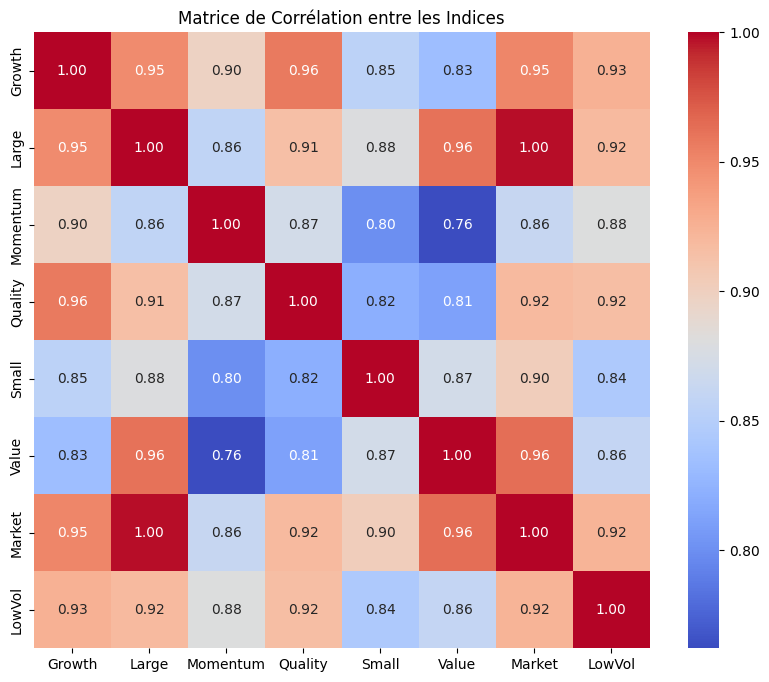

In [ ]:
# Calculer la matrice de corrélation entre les indices
all_returns = pd.DataFrame()

for key, data in filtered_data.items():
    # Ajouter les rendements de chaque indice à un DataFrame commun
    all_returns[key] = data['% Change']

# Calculer la matrice de corrélation
correlation_matrix = all_returns.corr()

# Visualiser la matrice de corrélation avec Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, square=True)
plt.title("Matrice de Corrélation entre les Indices")
plt.show()

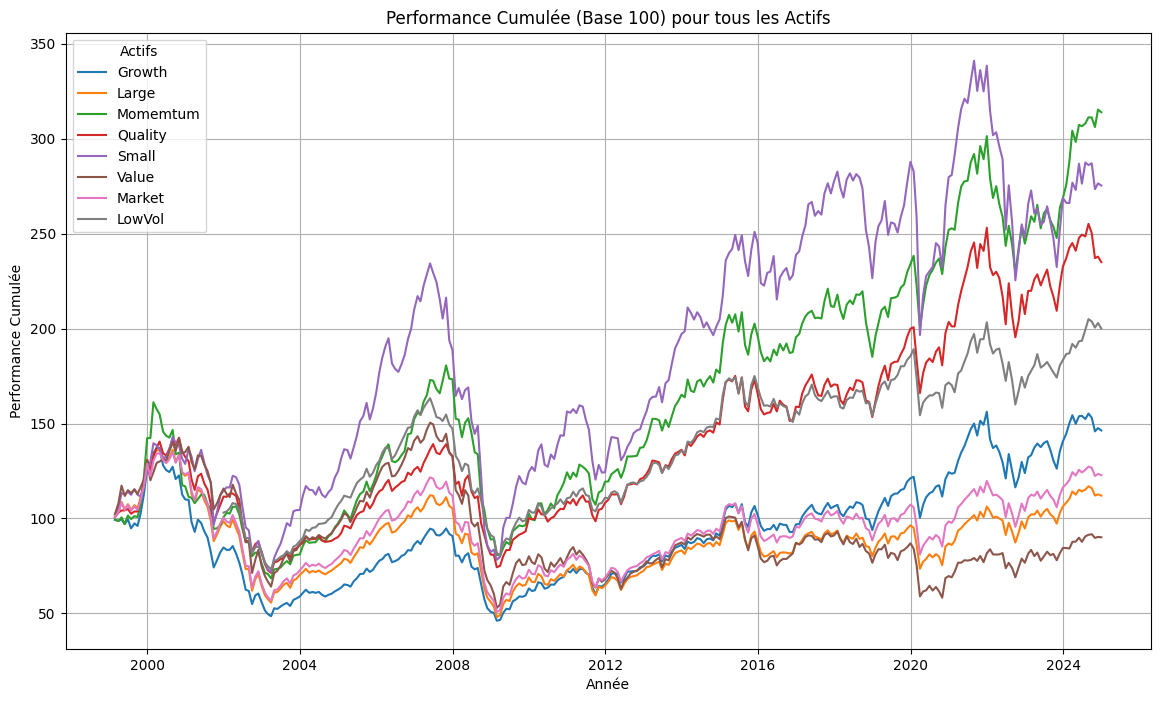

In [ ]:
# Tracer la performance cumulée pour tous les actifs sur le même graphique
plt.figure(figsize=(14, 8))

for key, data in filtered_data.items():
    plt.plot(data['Date'], (1 + data['Total Return']) * 100, label=key)

plt.title('Performance Cumulée (Base 100) pour tous les Actifs')
plt.xlabel('Année')
plt.ylabel('Performance Cumulée')
plt.grid(True)
plt.legend(title='Actifs')
plt.show()

In [57]:
# Définir les périodes d'analyse
periods = [
    ('1998-12-31', '2003-12-31'),
    ('2003-12-31', '2007-12-31'),
    ('2007-12-31', '2009-12-31'),
    ('2009-12-31' , '2012-12-31'),
    ('2012-12-31', '2019-12-31'),
    ('2019-12-31', '2021-12-31'),
    ('2021-12-31', '2024-12-31')
]

# Dictionnaire pour stocker les résultats
sequential_results = {period: {} for period in periods}

# Calculer la performance et la volatilité pour chaque période et chaque indice
for (start_date, end_date) in periods:
    # DataFrame pour stocker les rendements de chaque indice pour la période
    period_returns = pd.DataFrame()

    for key, data in filtered_data.items():
        period_data = data[(data['Date'] > start_date) & (data['Date'] <= end_date)]

        if not period_data.empty:
            # Ajouter les rendements de chaque indice à un DataFrame commun pour la période
            period_returns[key] = period_data['% Change']

            # Rebase the performance to 100 at the start of each period
            period_data['Cumulative Return'] = (1 + period_data['% Change']).cumprod() * 100

            # Calculer le rendement mensuel moyen
            monthly_return = period_data['% Change'].mean()

            # Calculer le rendement annualisé
            annualized_return = (1 + monthly_return)**12 - 1

            # Calculer la volatilité annualisée
            volatility = period_data['% Change'].std() * np.sqrt(12)

            # Calculer le Maximum Drawdown en termes de prix puis en pourcentage pour chaque indice
            period_data['Cumulative Peak Price'] = period_data['Price'].cummax()
            period_data['Drawdown Price'] = period_data['Price'] - period_data['Cumulative Peak Price']
            max_drawdown_price = period_data['Drawdown Price'].min()
            max_drawdown_percentage = (max_drawdown_price / period_data.loc[period_data['Drawdown Price'].idxmin(), 'Cumulative Peak Price']) * 100

            # Stocker les résultats pour chaque indice
            sequential_results[(start_date, end_date)][key] = {
                'Annualized Return': annualized_return,
                'Annualized Volatility': volatility,
                'Max Drawdown': max_drawdown_percentage
            }

    # Calculer la matrice de corrélation pour la période
    correlation_matrix = period_returns.corr()

    # Afficher la matrice de corrélation pour la période
    print(f"Matrice de corrélation pour la période {start_date} - {end_date} :")
    print(correlation_matrix, "\n")

# Afficher les résultats pour chaque période
for (start_date, end_date), results in sequential_results.items():
    print(f"Résultats pour la période {start_date} - {end_date} :")
    results_df = pd.DataFrame(results).transpose()
    print(results_df, "\n")


Matrice de corrélation pour la période 1998-12-31 - 2003-12-31 :
            Growth     Large  Momentum   Quality     Small     Value  \
Growth    1.000000  0.959360  0.849187  0.953871  0.812553  0.843786   
Large     0.959360  1.000000  0.797138  0.922630  0.854035  0.958275   
Momentum  0.849187  0.797138  1.000000  0.807333  0.718426  0.679798   
Quality   0.953871  0.922630  0.807333  1.000000  0.802773  0.832493   
Small     0.812553  0.854035  0.718426  0.802773  1.000000  0.842701   
Value     0.843786  0.958275  0.679798  0.832493  0.842701  1.000000   
Market    0.956962  0.998563  0.795490  0.927518  0.864260  0.963135   
LowVol    0.954135  0.939701  0.943436  0.951364  0.926905  0.917638   

            Market    LowVol  
Growth    0.956962  0.954135  
Large     0.998563  0.939701  
Momentum  0.795490  0.943436  
Quality   0.927518  0.951364  
Small     0.864260  0.926905  
Value     0.963135  0.917638  
Market    1.000000  0.945214  
LowVol    0.945214  1.000000   

Matri

C:\Users\wilso\AppData\Local\Temp\ipykernel_1472\3194214578.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['Cumulative Return'] = (1 + period_data['% Change']).cumprod() * 100
C:\Users\wilso\AppData\Local\Temp\ipykernel_1472\3194214578.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['Cumulative Peak Price'] = period_data['Price'].cummax()
C:\Users\wilso\AppData\Local\Temp\ipykernel_1472\3194214578.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [58]:
# Définir les périodes d'analyse
periods = [
    ('1998-12-31', '2003-12-31'),
    ('2003-12-31', '2007-12-31'),
    ('2007-12-31', '2009-12-31'),
    ('2009-12-31' , '2012-12-31'),
    ('2012-12-31', '2019-12-31'),
    ('2019-12-31', '2021-12-31'),
    ('2021-12-31', '2024-12-31')
]

# Dictionnaire pour stocker les résultats
sequential_results = {period: {} for period in periods}

# Calculer la performance et la volatilité pour chaque période et chaque indice
for key, data in filtered_data.items():
    for (start_date, end_date) in periods:
        period_data = data[(data['Date'] > start_date) & (data['Date'] <= end_date)]

        if not period_data.empty:
            # Rebase the performance to 100 at the start of each period
            period_data['Cumulative Return'] = (1 + period_data['% Change']).cumprod() * 100

            # Calculer le rendement mensuel moyen
            monthly_return = period_data['% Change'].mean()

            # Calculer le rendement annualisé
            annualized_return = (1 + monthly_return)**12 - 1

            # Calculer la volatilité annualisée
            volatility = period_data['% Change'].std() * np.sqrt(12)

            # Calculer le Maximum Drawdown en termes de prix puis en pourcentage pour chaque indice
            period_data['Cumulative Peak Price'] = period_data['Price'].cummax()
            period_data['Drawdown Price'] = period_data['Price'] - period_data['Cumulative Peak Price']
            max_drawdown_price = period_data['Drawdown Price'].min()
            max_drawdown_percentage = (max_drawdown_price / period_data.loc[period_data['Drawdown Price'].idxmin(), 'Cumulative Peak Price']) * 100

            # Stocker les résultats pour chaque indice
            sequential_results[(start_date, end_date)][key] = {
                'Annualized Return': annualized_return,
                'Annualized Volatility': volatility,
                'Max Drawdown': max_drawdown_percentage
            }

# Afficher les résultats pour chaque période
for (start_date, end_date), results in sequential_results.items():
    print(f"Résultats pour la période {start_date} - {end_date} :")
    results_df = pd.DataFrame(results).transpose()
    print(results_df, "\n")


Résultats pour la période 1998-12-31 - 2003-12-31 :
          Annualized Return  Annualized Volatility  Max Drawdown
Growth            -0.085615               0.190150    -62.282496
Large             -0.051654               0.190987    -56.373455
Momentum          -0.026099               0.182919    -55.741827
Quality           -0.018361               0.155701    -48.056322
Small              0.028187               0.193500    -46.298784
Value             -0.008943               0.201143    -51.639999
Market            -0.046046               0.187891    -55.298364
LowVol            -0.050191               0.137227    -31.076961 

Résultats pour la période 2003-12-31 - 2007-12-31 :
          Annualized Return  Annualized Volatility  Max Drawdown
Growth             0.117078               0.076543     -5.230700
Large              0.109223               0.078329     -5.982745
Momentum           0.214984               0.100186     -6.580209
Quality            0.117711               0.07520

C:\Users\wilso\AppData\Local\Temp\ipykernel_1472\1659622559.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['Cumulative Return'] = (1 + period_data['% Change']).cumprod() * 100
C:\Users\wilso\AppData\Local\Temp\ipykernel_1472\1659622559.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['Cumulative Peak Price'] = period_data['Price'].cummax()
C:\Users\wilso\AppData\Local\Temp\ipykernel_1472\1659622559.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [ ]:
# Dictionnaire pour stocker les résultats de bêta
beta_results = {period: {} for period in periods}

# Calculer le bêta pour chaque indice par rapport à l'indice de marché pour chaque période
market_data = filtered_data['Market']

for (start_date, end_date) in periods:
    market_period_data = market_data[(market_data['Date'] > start_date) & (market_data['Date'] <= end_date)]

    for key, data in filtered_data.items():
        if key != 'Market':
            period_data = data[(data['Date'] > start_date) & (data['Date'] <= end_date)]

            if not period_data.empty and not market_period_data.empty:
                # Calculer le '% Change' basé sur le logarithme naturel des prix
                period_data['% Change'] = np.log(period_data['Price'] / period_data['Price'].shift(1))
                market_period_data['% Change'] = np.log(market_period_data['Price'] / market_period_data['Price'].shift(1))

                # Aligner les données avec celles de l'indice de marché
                merged_data = pd.merge(period_data[['Date', '% Change']], market_period_data[['Date', '% Change']], on='Date', suffixes=('', '_Market'))

                # Supprimer les valeurs manquantes
                merged_data = merged_data.dropna(subset=['% Change', '% Change_Market'])

                # Vérifier s'il reste des données après suppression des valeurs manquantes
                if not merged_data.empty:
                    # Calculer le bêta en utilisant la régression linéaire
                    slope, intercept, r_value, p_value, std_err = linregress(merged_data['% Change_Market'], merged_data['% Change'])
                    beta_results[(start_date, end_date)][key] = slope
                else:
                    beta_results[(start_date, end_date)][key] = None

# Afficher les résultats de bêta pour chaque période et chaque indice
for (start_date, end_date), results in beta_results.items():
    print(f"Bêtas pour la période {start_date} - {end_date} :")
    for key, beta in results.items():
        print(f"Bêta pour {key}: {beta}")
    print("\n")

C:\Users\wilso\AppData\Local\Temp\ipykernel_1472\1789536770.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['% Change'] = np.log(period_data['Price'] / period_data['Price'].shift(1))
C:\Users\wilso\AppData\Local\Temp\ipykernel_1472\1789536770.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_period_data['% Change'] = np.log(market_period_data['Price'] / market_period_data['Price'].shift(1))
C:\Users\wilso\AppData\Local\Temp\ipykernel_1472\1789536770.py:16: SettingWithCopyWarning: 

Bêtas pour la période 1998-12-31 - 2003-12-31 :
Bêta pour Growth: 0.9684710019301404
Bêta pour Large: 1.0150196105179559
Bêta pour Momemtum: 0.7725399341141489
Bêta pour Quality: 0.7828506783327468
Bêta pour Small: 0.89006231538142
Bêta pour Value: 1.0310697640604058
Bêta pour LowVol: 0.6007967874850683


Bêtas pour la période 2003-12-31 - 2007-12-31 :
Bêta pour Growth: 0.890101577897689
Bêta pour Large: 0.9404296349431093
Bêta pour Momemtum: 1.1030806750943887
Bêta pour Quality: 0.8347918009653496
Bêta pour Small: 1.402559275644693
Bêta pour Value: 1.1111588289703256
Bêta pour LowVol: 0.8061106378652576


Bêtas pour la période 2007-12-31 - 2012-12-31 :
Bêta pour Growth: 0.8552154312159321
Bêta pour Large: 0.9811312342147236
Bêta pour Momemtum: 0.8057866452503173
Bêta pour Quality: 0.719338928908433
Bêta pour Small: 1.1775463827737362
Bêta pour Value: 1.1533059479177512
Bêta pour LowVol: 0.6587173048255295


Bêtas pour la période 2012-12-31 - 2019-12-31 :
Bêta pour Growth: 0.9369364259

C:\Users\wilso\AppData\Local\Temp\ipykernel_1472\1789536770.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['% Change'] = np.log(period_data['Price'] / period_data['Price'].shift(1))
C:\Users\wilso\AppData\Local\Temp\ipykernel_1472\1789536770.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_period_data['% Change'] = np.log(market_period_data['Price'] / market_period_data['Price'].shift(1))
C:\Users\wilso\AppData\Local\Temp\ipykernel_1472\1789536770.py:16: SettingWithCopyWarning: 

In [56]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Charger les données de Fama French
fama_french_data = pd.read_csv('Europe_5_Factors_v2.csv', delimiter=';')
fama_french_data['Date'] = pd.to_datetime(fama_french_data['Date'], format='%m/%d/%y')

# Liste des fichiers et lecture des données
files = {
    'Growth': 'MSCI_EUROPE_GROWTH.xlsx',
    'Large': 'MSCI_EUROPE_LARGE.xlsx',
    'Momentum': 'MSCI_EUROPE_MOMENTUM.xlsx',
    'Quality': 'MSCI_EUROPE_QUALITY.xlsx',
    'Small': 'MSCI_EUROPE_SMALL.xlsx',
    'Value': 'MSCI_EUROPE_VALUE.xlsx',
    'Market': 'MSCI_EUROPE.xlsx',
    'LowVol': 'MSCI_EUROPE_LOW_VOL.xlsx'
}

filtered_data = {}  # Initialize the dictionary to store filtered data
regression_results = {}  # Initialize the dictionary to store regression results

# Charger et préparer les données pour chaque indice
for key, file in files.items():
    # Charger les données de l'indice
    data = pd.read_excel(file, skiprows=2)

    # Renommer les colonnes pour plus de clarté
    data.columns = ['Date', 'Price', 'CVol', 'Change', '% Change', 'Total Return', 'Cumulative Return', 'Open', 'High', 'Low']

    # Convertir la colonne 'Date' en type datetime
    data['Date'] = pd.to_datetime(data['Date'])

    # Filtrer les données pour conserver uniquement les dates entre le 31/12/1998 et le 31/12/2024
    data = data[(data['Date'] > '1998-12-31') & (data['Date'] <= '2024-12-31')]

    # Convertir la colonne 'Price' en float
    data['Price'] = pd.to_numeric(data['Price'], errors='coerce')

    # Vérifier et gérer les valeurs manquantes dans 'Price'
    if data['Price'].isnull().any():
        data['Price'] = data['Price'].fillna(method='ffill')

    # Calculer le '% Change' basé sur le logarithme naturel des prix
    data['% Change'] = np.log(data['Price'] / data['Price'].shift(1))

    # Stocker les données filtrées
    filtered_data[key] = data

# Effectuer la régression linéaire pour chaque indice par rapport au marché
market_data = filtered_data['Market']

for key, data in filtered_data.items():
    if key != 'Market':
        # Aligner les données avec celles de Fama French
        merged_data = pd.merge(data[['Date', '% Change']], fama_french_data, on='Date', how='inner')

        # Supprimer les valeurs manquantes
        clean_data = merged_data.dropna(subset=['% Change', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'])

        # Définir les variables indépendantes (facteurs) et la variable dépendante (rendement de l'indice)
        X = clean_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
        y = clean_data['% Change']

        # Ajouter une constante au modèle pour l'intercept (alpha)
        X = sm.add_constant(X)

        # Effectuer la régression linéaire multiple
        model = sm.OLS(y, X).fit()

        # Stocker les résultats de la régression
        regression_results[key] = model

        # Afficher les résultats du modèle
        print(f"Résultats de la régression pour {key} :")
        print(model.summary())
        print("\n")

# Afficher les résultats de régression pour chaque indice
for key, model in regression_results.items():
    print(f"Résultats de la régression pour {key} :")
    print(f"Alpha: {model.params['const']:.4f}")
    for factor, beta in zip(['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'], model.params[1:]):
        print(f"Bêta pour {factor}: {beta:.4f}")
    print(f"Erreur (Résidus moyens): {model.resid.mean():.4f}")
    print("\n")



C:\Users\wilso\AppData\Local\Temp\ipykernel_1472\2244885615.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Price'] = data['Price'].fillna(method='ffill')


Résultats de la régression pour Growth :
                            OLS Regression Results                            
Dep. Variable:               % Change   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     170.0
Date:                Tue, 25 Mar 2025   Prob (F-statistic):           6.27e-85
Time:                        23:19:54   Log-Likelihood:                 733.46
No. Observations:                 303   AIC:                            -1455.
Df Residuals:                     297   BIC:                            -1433.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

C:\Users\wilso\AppData\Local\Temp\ipykernel_1472\2244885615.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Price'] = data['Price'].fillna(method='ffill')


In [55]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Charger les données de Fama French
fama_french_data = pd.read_csv('Europe_5_Factors_v2.csv', delimiter=';')
fama_french_data['Date'] = pd.to_datetime(fama_french_data['Date'], format='%m/%d/%y')

# Liste des fichiers et lecture des données
files = {
    'Growth': 'MSCI_EUROPE_GROWTH.xlsx',
    'Large': 'MSCI_EUROPE_LARGE.xlsx',
    'Momentum': 'MSCI_EUROPE_MOMENTUM.xlsx',
    'Quality': 'MSCI_EUROPE_QUALITY.xlsx',
    'Small': 'MSCI_EUROPE_SMALL.xlsx',
    'Value': 'MSCI_EUROPE_VALUE.xlsx',
    'Market': 'MSCI_EUROPE.xlsx',
    'LowVol': 'MSCI_EUROPE_LOW_VOL.xlsx'
}

filtered_data = {}  # Initialize the dictionary to store filtered data
regression_results = {}  # Initialize the dictionary to store regression results

# Charger et préparer les données pour chaque indice
for key, file in files.items():
    # Charger les données de l'indice
    data = pd.read_excel(file, skiprows=2)

    # Renommer les colonnes pour plus de clarté
    data.columns = ['Date', 'Price', 'CVol', 'Change', '% Change', 'Total Return', 'Cumulative Return', 'Open', 'High', 'Low']

    # Convertir la colonne 'Date' en type datetime
    data['Date'] = pd.to_datetime(data['Date'])

    # Filtrer les données pour conserver uniquement les dates entre le 31/12/1998 et le 31/12/2024
    data = data[(data['Date'] > '1998-12-31') & (data['Date'] <= '2024-12-31')]

    # Convertir la colonne 'Price' en float
    data['Price'] = pd.to_numeric(data['Price'], errors='coerce')

    # Vérifier et gérer les valeurs manquantes dans 'Price'
    if data['Price'].isnull().any():
        data['Price'] = data['Price'].fillna(method='ffill')

    # Calculer le '% Change' basé sur le logarithme naturel des prix
    data['% Change'] = np.log(data['Price'] / data['Price'].shift(1))

    # Stocker les données filtrées
    filtered_data[key] = data

# Initialiser un DataFrame pour stocker les résultats de régression
results_df = pd.DataFrame(index=['Alpha', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Mean Residuals'])

# Effectuer la régression linéaire pour chaque indice par rapport au marché
for key, data in filtered_data.items():
    # Aligner les données avec celles de Fama French
    merged_data = pd.merge(data[['Date', '% Change']], fama_french_data, on='Date', how='inner')

    # Supprimer les valeurs manquantes
    clean_data = merged_data.dropna(subset=['% Change', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'])

    # Définir les variables indépendantes (facteurs) et la variable dépendante (rendement de l'indice)
    X = clean_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
    y = clean_data['% Change']

    # Ajouter une constante au modèle pour l'intercept (alpha)
    X = sm.add_constant(X)

    # Effectuer la régression linéaire multiple
    model = sm.OLS(y, X).fit()

    # Stocker les résultats de la régression
    regression_results[key] = model

    # Extraire les coefficients et les résidus moyens
    results_df[key] = [model.params['const']] + list(model.params[1:]) + [model.resid.mean()]

# Exporter les résultats dans un fichier Excel
results_df.to_excel('regression_results_v2.xlsx')
print("Les résultats ont été exportés dans le fichier 'regression_results.xlsx'.")


C:\Users\wilso\AppData\Local\Temp\ipykernel_1472\2235421645.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Price'] = data['Price'].fillna(method='ffill')
C:\Users\wilso\AppData\Local\Temp\ipykernel_1472\2235421645.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Price'] = data['Price'].fillna(method='ffill')


Les résultats ont été exportés dans le fichier 'regression_results.xlsx'.
